Introduction
--------------

In the last section, we used windows for spectral analysis and  noted that while windows helped distinguish weak signals buried in the sidelobes of nearby  stronger signals, there were many trade-offs involved. In this section, we put together the standard framework for analyzing and categorizing  windows. There are many, many windows used in signal processing, so we begin by considering the common characteristics of windows and then move on to developing the standard metrics for them.

### Spectral Leakage

Because computer memory is finite, we  must analyze a finite section of data. The key underlying assumption of the DFT is that the finite section is periodic with period $N_s$. When this actually turns out to be true, it is possible to exactly capture discrete frequencies. For example, given

$$ x_n = \sin \left(\frac{2\pi f_o n }{f_s} \right) $$

with $ N_s = f_s/f_o = N$

the following figure shows the effect of *spectral leakage*.

/home/bagustris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/bagustris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/bagustris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of 

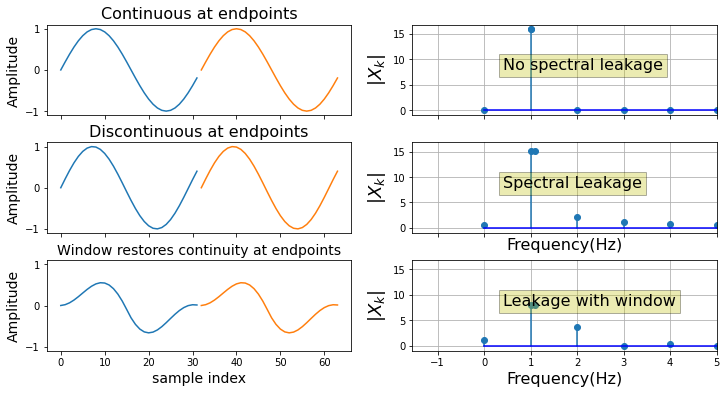

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

fo = 1 # signal frequency
fs = 32 # sample frequency
Ns = 32 # number of samples
x = np.sin( 2*np.pi*fo/fs*np.arange(Ns)) # sampled signal
fig,axs= plt.subplots(3,2,sharex='col',sharey='col')
fig.set_size_inches((12,6))
plt.subplots_adjust(hspace=.3)

ax=axs[0,0]
ax.plot(np.arange(Ns),x,label='signal')
ax.plot(np.arange(Ns)+Ns,x,label='extension')
ax.set_ylabel('Amplitude',fontsize=14)
ax.set_title('Continuous at endpoints',fontsize=16)

ax=axs[0,1]
N=Ns  #chosen so DFT bin is exactly on fo
Xm = abs(np.fft.fft(x,N))
idx = int(fo/(fs/N))
ax.stem(np.arange(N)/N*fs,Xm,basefmt='b-')
ax.plot( fo, Xm[idx],'o')
ax.set_ylabel(r'$|X_k|$',fontsize=18)
ax.set_xlim(xmax = 5)
ax.set_ylim(ymin=-1)
ax.text(0.3,0.5,'No spectral leakage',fontsize=16,
        transform=ax.transAxes,
        bbox={'fc':'y','alpha':.3})
ax.grid()

# loss of continuity case

fo = 1.1 # signal frequency
x = np.sin( 2*np.pi*fo/fs*np.arange(Ns)) # sampled signal

ax=axs[1,0]
ax.plot(np.arange(Ns),x,label='signal')
ax.plot(np.arange(Ns)+Ns,x,label='extension')
ax.set_ylabel('Amplitude',fontsize=14)
ax.set_title('Discontinuous at endpoints',fontsize=16)

ax=axs[1,1]
Xm = abs(np.fft.fft(x,N))
idx = int(fo/(fs/N))
ax.stem(np.arange(N)/N*fs,Xm,basefmt='b-')
ax.plot( fo, Xm[idx],'o')
ax.set_xlabel('Frequency(Hz)',fontsize=16)
ax.set_ylabel(r'$|X_k|$',fontsize=18)
ax.text(0.3,0.5,'Spectral Leakage',fontsize=16,
        transform=ax.transAxes,
        bbox={'fc':'y','alpha':.3})
ax.set_xlim(xmax = 5)
ax.set_ylim(ymin=-1)
ax.grid()

x = x*signal.triang(Ns,2)
ax=axs[2,0]
ax.plot(np.arange(Ns),x,label='signal')
ax.plot(np.arange(Ns)+Ns,x,label='extension')
ax.set_xlabel('sample index',fontsize=14)
ax.set_ylabel('Amplitude',fontsize=14)
ax.set_title('Window restores continuity at endpoints',fontsize=14)

ax=axs[2,1]
Xm = abs(np.fft.fft(x,N))
idx = int(fo/(fs/N))
ax.stem(np.arange(N)/N*fs,Xm,basefmt='b-')
ax.plot( fo, Xm[idx],'o')
ax.set_xlabel('Frequency(Hz)',fontsize=16)
ax.set_ylabel(r'$|X_k|$',fontsize=18)
ax.text(0.3,0.5,'Leakage with window',fontsize=16,
        transform=ax.transAxes,
        bbox={'fc':'y','alpha':.3})
ax.set_xlim(xmax = 5)
ax.set_ylim(ymin=-1)
ax.grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


In the above figure, the top row shows the ideal situation where the sampling interval captures exactly one period of the signal and the DFT bin is exactly on the signal frequency. The DFT assumes that the section of the signal repeats            end-to-end with the sampling interval, implying no discontinuities at the joining ends. In practice, this never happens because we don't know the signal frequency ahead of time (if we did, there would be no point in spectral analysis!).

The second row shows the case when the signal's period is *different* from the sampling interval and there is a discontinuity at the joining ends. When this happens, the DFT cannot perfectly isolate the signal's frequency and thus *leaks* energy into other frequency bins. This is known as *spectral leakage* and it causes bias in the frequency estimate.

The third row shows using a window to reduce the discontinuity at edges. The corresponding DFT still exhibits spectral leakage so windows do not entirely cure this problem, but they do help in other ways. The remainder of this section explores the many ways to analyze windows and their effects and provides some guidelines for choosing windows in practice.

The following figure shows how window functions affect the signal's power.

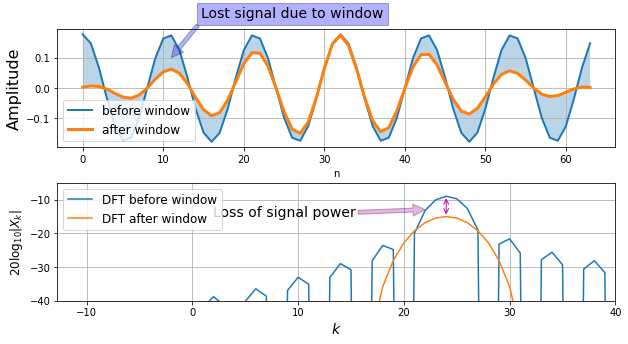

In [2]:
# some useful functions 
def dftmatrix(Nfft=32,N=None):
    'construct DFT matrix'
    k= np.arange(Nfft)
    if N is None: N = Nfft
    n = np.arange(N)
    U = np.matrix(np.exp(1j* 2*np.pi/Nfft *k*n[:,None])) # use numpy broadcasting to create matrix
    return U/np.sqrt(Nfft)

def db20(W,Nfft=None):
    'Given DFT, return power level in dB'
    if Nfft is None: # assume W is DFT 
        return 20*log10(abs(W))
    else: # assume time-domain passed, so need DFT
        DFT= np.fft.fft(np.array(W).flatten(),Nfft)/np.sqrt(Nfft)
        return 20*np.log10(abs(DFT.flatten()))

U=dftmatrix(64) 
u=U[:,6].real*np.sqrt(2) # create test sinusoid
fo = 2*np.pi/64*6 # in radians/sec
nz = np.random.randn(64,1) # noise samples
w=signal.triang(64) # window function

fig,ax= plt.subplots(2,1)
fig.set_size_inches((10,5))
plt.subplots_adjust(hspace=.3)
n = np.arange(len(u))
ax[0].plot(n,u.real,label='before window',lw=2)
ax[0].set_ylabel('Amplitude',fontsize=16)
ax[0].plot(n,np.diag(w)*u.real,label='after window',lw=3.)
ax[0].fill_between(n,np.array(u).flat, np.array(np.diag(w)*u).flat,alpha=0.3)
ax[0].legend(loc=0,fontsize=12)
ax[0].set_xlabel('n')
ax[0].grid()
ax[0].annotate('Lost signal due to window',fontsize=14, bbox={'fc':'b','alpha':.3},
      xy=(11,0.1),
      xytext=(30,40), textcoords='offset points',
      arrowprops={'facecolor':'b','alpha':.3})

N=256 # DFT size for plot
idx = int(fo/(2*np.pi/N))
ax[1].plot(db20(u,N),label='DFT before window')
ax[1].plot(db20(np.diag(w)*u,N),label='DFT after window')
ax[1].set_ylim(ymin=-40,ymax=-5)
ax[1].set_xlim(xmax=40)
ax[1].set_ylabel(r'$20\log_{10}|X_k|$',fontsize=12)
ax[1].set_xlabel(r'$k$',fontsize=14)
ax[1].annotate('Loss of signal power',fontsize=14,xy=(22,-13),
            xytext=(2,-15),
            arrowprops={'facecolor':'m','alpha':.3})
pkU = db20(u,N)[idx]
pkW = db20(np.diag(w)*u,N)[idx]
ax[1].annotate('',xy=(idx,pkW),xytext=(idx,pkU),fontsize=12,
               arrowprops={'arrowstyle':'<->','color':'m'})
ax[1].legend(loc=0,fontsize=12)
ax[1].grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dnp.pi=300)


The figure above shows the loss in signal due to the window in the sample domain (top plot) and in the DFT-domain (bottom plot). The shaded region in the top plot shows the signal that has been eliminated due to the window, which slopes to zero away from the edges. The bottom plot shows the DFTs of the signal before and after windowing. As indicated, the loss in power is the drop in the DFT at the signal frequency, $f_o$. Note that the mainlobe of the windowed DFT is *much* larger than before which makes it harder to separate two nearby frequencies that are separated less than the width of the mainlobe. In general, losing signal power is not good, but we seldom consider the signal in isolation; rather, we always  regard  the signal in terms of its relationship to ever-present noise.

### Signal-to-Noise Ratio

To analyze the effect of windows, we define the signal-to-noise ratio and then compute it before and after applying the window function. For simplicity, we consider a perfect narrowband signal at frequency $f_o$ with amplitude, $ A $,

$$ \mathbf{x} = A \mathbf{u}_o $$

where 

$$ \mathbf{u}_o =\frac{1}{\sqrt N_s} \left[ \exp \left( j \frac{2\pi f_o }{f_s} n\right) \right]_{n=0}^{N_s-1}$$

with signal power equal to $A^2$. We'll assume the noise power is $\sigma_\nu^2$. Thus, the pre-window signal-to-noise ratio is,

$$ SNR_{pre} = \frac{A^2}{\sigma_\nu^2}$$

After applying the window, the updated signal power at $f=f_o$ becomes

$$ \DeclareMathOperator{\diag}{diag}
|\mathbf{u}^H_o \left(  \mathbf{w} \odot \mathbf{x}  \right)|^2= |\mathbf{u}^H_o  \diag (\mathbf{w}) \mathbf{x}|^2 = A^2 |\mathbf{1}^T \mathbf{w}|^2$$

with corresponding noise power

$$ \DeclareMathOperator{\Tr}{Trace}
\mathbb{E} | \mathbf{w} \odot \mathbf{n} |^2 = \Tr \left( \diag(\mathbf{w}) \mathbb{E} \left(   \mathbf{n}\mathbf{n}^T \right)\diag(\mathbf{w}) \right) = \Tr \left(\diag(\mathbf{w}) \sigma_\nu^2 \mathbf{I}
\diag(\mathbf{w}) \right) = \sigma_\nu^2 \mathbf{w}^T \mathbf{w}$$

where $ \mathbb{E}\left( \mathbf{n} \mathbf{n}^T \right)= \sigma_\nu^2 \mathbf{I}$ and $\mathbf{n}$ is a vector of mutually uncorrelated noise samples with variance $\sigma_\nu^2$.

Thus the post-window signal-to-noise ratio is

$$ SNR_{post} = \frac{ A^2 |\mathbf{1}^T \mathbf{w}|^2}{\sigma_\nu^2 \mathbf{w}^T \mathbf{w}} $$

Finally, the ratio of the post-window to pre-window  signal-to-noise ratios is defined as the *processing gain*,

$$ G_p \triangleq \frac{SNR_{post}}{SNR_{pre}} = \frac{ |\mathbf{1}^T \mathbf{w}|^2}{\mathbf{w}^T \mathbf{w}} $$

Incidentally, the *coherent gain* is defined the ratio of the *amplitudes* of the input and output signals,

$$ G_{coh} \triangleq \mathbf{1}^T \mathbf{w}$$

Thus, the window reduces signal power *and* noise power so the net effect is to increase the signal-to-noise ratio. Processing gain summarizes the effect. 

### Equivalent Noise Bandwidth

Thus far, we have observed that the window can improve the signal-to-noise ratio because it reduces noise power less than it reduces signal power. However, this considers noise across the entire frequency domain and we want a metric to measure noise power around the mainlobe of the window's DFT. Then, we can think  about windows in terms of the amount of noise they *pass* through the mainlobe. The figure below illustrates this concept.

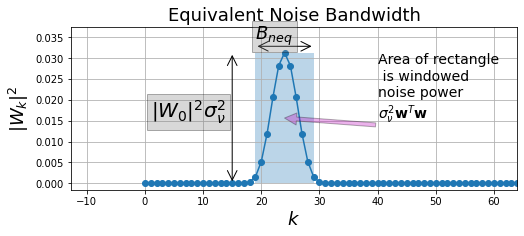

In [3]:
from matplotlib.patches import Rectangle

fig,ax = plt.subplots()
fig.set_size_inches((8,3))

N = 256 # DFT size
idx = int(fo/(2*np.pi/N))
Xm = abs(np.fft.fft(np.array(np.diag(w)*u).flatten(),N)/np.sqrt(N))**2
ax.plot(Xm,'-o')
ax.add_patch(Rectangle((idx-10/2,0),width=10,height=Xm[idx],alpha=0.3))
ax.set_xlim(xmax = N/4)
ax.set_ylabel(r'$|W_k|^2$',fontsize=18)
ax.set_xlabel(r'$k$',fontsize=18)
ax.set_title('Equivalent Noise Bandwidth',fontsize=18)
ax.annotate('Area of rectangle\n is windowed\nnoise power\n'\
              +r'$\sigma_\nu^2 \mathbf{w}^T \mathbf{w}$',
            fontsize=14,
            xy=(idx,Xm.max()/2.),
            xytext=(40,Xm.max()/2.),
            arrowprops={'facecolor':'m','alpha':.3});
ax.annotate('',ha='center',fontsize=24,
             xy=(idx+10/2,Xm.max()*1.05),
             xytext=(idx-10/2,Xm.max()*1.05),
             arrowprops=dict(arrowstyle='<->'))
ax.annotate('',ha='center',fontsize=24,
             xy=(15,0),
             xytext=(15,Xm.max()),
             arrowprops=dict(arrowstyle='<->'))
ax.text( 1, Xm.max()/2,r'$ |W_0|^2\sigma_\nu^2 $',fontsize=20,bbox={'fc':'gray','alpha':.3})
ax.text( idx-5, Xm.max()*1.1,r'$B_{neq}$',fontsize=18,bbox={'fc':'gray','alpha':.3})
ax.set_ylim(ymax = Xm.max()*1.2)
ax.grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


The figure above shows the squared DFT of the window with the overlaid rectangle showing the idealized bandpass filter that would pass the same amount of noise power at the peak of the window's DFT. Thus, it's as if we gathered up all the noise power and centered it at the peak of the mainlobe. This is the *Equivalent Noise Bandwidth* (ENBW) concept. The post-window noise power is the following: 

$$\mathbb{E} || \mathbf{w} \odot \mathbf{n} ||^2 =  \sigma_{\nu}^2 \mathbf{w}^T \mathbf{w }$$

We want to equate this power (which is spread over all frequencies) to the corresponding output noise power of a perfect bandlimited filter with height equal to $W_0$ and width $ B_{neq}$. 

$$   B_{neq} \cdot W_0^2 \sigma_\nu^2 = \sigma_{\nu}^2 \mathbf{w}^T \mathbf{w } $$

and solving for $B_{neq}$ gives,

$$  B_{neq}  = \mathbf{w}^T \mathbf{w } / W_0^2   $$

and since $W_0 = \mathbf{1}^T \mathbf{ w}$, we can write this as the following,

$$  B_{neq}  \triangleq \frac{\mathbf{w}^T \mathbf{w } }{ |\mathbf{1}^T \mathbf{w}|^2 } =\frac{1}{G_p} $$

which shows how closely related this is to processing gain. The intuition here is that the larger the noise equivalent bandwidth, the more noise is passed through the mainlobe, thus competing more with the signal at the nominal center of the lobe, thus reducing the processing gain of the window.

The following table reports the equivalent noise bandwidth for some popular windows normalized to the rectangular window's value. Note that the windows in `scipy` are available in `scipy.signal.windows`. The values in the table are match Harris' exhaustive 1978 paper using the matching `symmetry` argument in the Python call. See the corresponding window documentation for implementation details.

<table border="1">
    <tr>
    <th> Window </th>
    <th>Python call</th>
    <th> ENBW (bins) </th>
    </tr>
    <tr>
        <td>rectangular</td><td style="font-family:monospace">windows.boxcar(Ns)</td><td style="text-align:center"> 1</td>
    </tr>
    <tr>
        <td>triangular</td><td style="font-family:monospace">windows.triang(Ns)</td><td style="text-align:center"> 1.33</td>
    </tr>
    <tr>
        <td>hamming</td><td style="font-family:monospace">windows.hamming(Ns,sym=False)</td><td style="text-align:center"> 1.36</td>
    </tr>   
    <tr>
        <td>blackman</td><td style="font-family:monospace">windows.blackman(Ns,sym=False)</td><td style="text-align:center"> 1.73</td>
    </tr>      
</table> 



## Summary

In this section, we explained the shape of windows functions in terms of spectral leakage and developed the concept of processing gain and equivalent noise bandwidth as closely related metrics for categorizing different window functions. The exhaustive 1978 paper by Harris (see references) is the primary reference work for many more windows functions than we discussed here. Note that the window functions are implemented in the `scipy.signal.windows` submodule but sometimes the normalization factors and defined parameters are slightly different from Harris' paper.  Sometimes the term *tapers* is used instead of *window functions* in certain applications. Lastly, window functions are also fundamental to antenna analysis for many of the same reasons, especially with respect to linear arrays.


As usual, the original corresponding IPython notebook for this post  is available for download [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Windowing_Part2.ipynb). 

Comments and corrections welcome!

References
---------------


* Oppenheim, A. V., and A. S. Willsky. *Signals and Systems* Prentice-Hall, (1997).
* Proakis, John G. *Digital signal processing: principles algorithms and applications* Pearson Education India, 2001.
* Harris, Fredric J. "On the use of windows for harmonic analysis with the discrete Fourier transform." Proceedings of the IEEE 66.1 (1978): 51-83.